In [1]:
import os 

import numpy as np
import pandas as pd
import scipy 

import progressbar

import re
import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt

import seaborn as sns

% matplotlib inline


In [2]:
data = pd.read_csv('../data/data.csv', encoding='latin1')
data.columns.values

array([u'Id', u'Title', u'Description', u'LikeCount', u'DislikeCount',
       u'ViewCount', u'FavoriteCount', u'CommentCount', u'PublishedAt',
       u'Channel Id', u'Channel Title', u'Tags', u'Thumbnail Default',
       u'nsfw_score'], dtype=object)

In [3]:
data.shape

(10517, 14)

In [4]:
df = data.copy()

In [27]:
def tokenize(s):
    regex_backslash = re.compile(r'\\n|\\')
    s = (regex_backslash.sub(" ", s))
    tokenizer = RegexpTokenizer(r'[\w\']+|![^\w\s]+')
    return tokenizer.tokenize(s)
    
def num_tokens_in_str(s):
    s = tokenize(s)
    return len(s)

def top_k_percentile_views_mask(df, k):
    top_k_percent = df['ViewCount'].nlargest(int(df.shape[0] * (k / 100.))).iloc[-1]
    return df['ViewCount'] > top_k_percent

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def GetTopKImportantWords(df, k, showprogress=False):
    allWords = df[['Title', 'Description']].apply(lambda x: x[0] + x[1], axis=1)

    tf = TfidfVectorizer(norm='l2', min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=tokenize)
    tf.fit(allWords)

    tfidf_title = tf.transform(df['Title'])
    tfidf_desc = tf.transform(df['Description'])
    top_list = []


    for tfidf in [tfidf_title, tfidf_desc]:
        dense = tfidf.todense()

        if showprogress:
            bar = progressbar.ProgressBar(max_value=len(dense))

        top_words = []
        feature_names = tf.get_feature_names()
        for i, sample in enumerate(dense):
            sample = np.array(sample.tolist()[0])
            scores = sample[sample > 0]
            words = pd.Series(feature_names)[sample > 0]
            scores = pd.Series(scores, words).sort_values(ascending=False)
            top_words.append(pd.Series(scores.index[0:k]))
            
            if showprogress:
                bar.update(i)
        top_list.append(pd.concat(top_words, axis=1).T)

    for i in range(k):
        df['Title-TopWords-{0}'.format(i + 1)] = top_list[0][i]
    for i in range(k):
        df['Description-TopWords-{0}'.format(i + 1)] = top_list[1][i]
    return df

In [50]:
# Trying to find some relationship between what's present in the titles.
def find_number_of_condition(s, condition):
    s = tokenize(s)
    num_detected_condition = 0 
    for token in s:
        if condition(token):
            num_detected_condition += 1
    return num_detected_condition

def num_words_all_caps(s):
    return find_number_of_condition(s, lambda x: x.isupper())

def num_how(s):
    return find_number_of_condition(s, lambda x: x.lower() == 'how')

def num_absolutes(s):
    absolute_words = ['best', 'most', 'never', 'top', 'guarantees', 'guaranteed', 'extreme']
    return find_number_of_condition(s, lambda x: x.lower() in absolute_words)

def num_exclamation(s):
    return s.count('!')

def num_me(s):
    # e.g. any time they say me or i
    me_words = ['i', 'me', 'my', 'mine', 'myself']
    return find_number_of_condition(s, lambda x: x.lower() in me_words)

def num_you(s):
    you_words = ['you', 'your', 'yours', 'yourself']
    return find_number_of_condition(s, lambda x: x.lower() in you_words)

condition_map = {
    'caps': num_words_all_caps,
    'how': num_how,
    'absolutes': num_absolutes, 
    'exclamations': num_exclamation,
    'me': num_me,
    'you': num_you,
}

In [51]:
df_t = df.copy()

new_columns = []
for key in condition_map.keys():
    column_name = 'num-{0}'.format(key)
    df_t[column_name] = df['Title'].astype(str).apply(condition_map[key])
    new_columns.append(column_name)
df_t = df_t[new_columns]
df_t['ViewCount'] = df['ViewCount']
df_t['Title'] = df['Title']

df_t['TotalUses'] = df_t['Title'].apply(lambda x: 0)
for new_column in new_columns:
    df_t['TotalUses'] += df_t[new_column]

df_t.head()

,num-me,num-caps,num-how,num-you,num-exclamations,num-absolutes,ViewCount,Title,TotalUses
0,0,0,0,0,4,0,13577683,300 pushups a day for 20 days!! - Results!!,4
1,0,0,0,0,0,0,9986096,John Cena - gym,0
2,0,0,0,0,0,0,8532402,Bodybuilding Motivation - No Time To Waste,0
3,0,0,0,0,1,1,8301027,Most Powerful Home Chest Workout Ever : Build ...,2
4,0,0,0,0,0,2,7141821,Greg Plitt Best of The Best Workout Video Prev...,2


In [66]:
k = 15
top_k_mask = top_k_percentile_views_mask(df, k)

for new_column in new_columns:
    top_k_used = (df_t[top_k_mask][new_column] > 0).sum() / (float(df_t[top_k_mask].shape[0]))
    total_used = (df_t[new_column] > 0).sum() / float(df_t.shape[0])
    print ("In top {0} percentile, {1}% used {2}".format(k, top_k_used, new_column))
    print ("In total, {0}% used a {1}".format(total_used, new_column))

In top 15 percentile, 0.0260152284264% used num-me
In total, 0.027384235048% used a num-me
In top 15 percentile, 0.368654822335% used num-caps
In total, 0.352857278692% used a num-caps
In top 15 percentile, 0.0583756345178% used num-how
In total, 0.0354663877532% used a num-how
In top 15 percentile, 0.0361675126904% used num-you
In total, 0.0285252448417% used a num-you
In top 15 percentile, 0.0951776649746% used num-exclamations
In total, 0.0665589046306% used a num-exclamations
In top 15 percentile, 0.0469543147208% used num-absolutes
In total, 0.0249120471617% used a num-absolutes


In [46]:
df_t[top_k_mask]['TotalUses'].describe()

count    1050.00000
mean        1.20000
std         1.96247
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max        14.00000
Name: TotalUses, dtype: float64

In [47]:
(df_t[top_k_mask]['TotalUses'] > 0).sum()

500

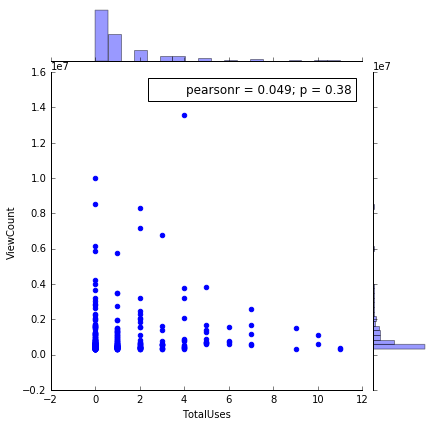

In [31]:
sns.jointplot(df_t[top_k_mask]['TotalUses'], df_t[top_k_mask]['ViewCount'])

In [7]:
df = GetTopKImportantWords(df, 3, showprogress=True)

 99% (10511 of 10517) |################## | Elapsed Time: 0:01:48 ETA:  0:00:00

In [22]:
df['LikePercentage'] = df['LikeCount'] / (df['DislikeCount'] + df['LikeCount'])

In [23]:
df.head(20)

,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,CommentCount,PublishedAt,Channel Id,...,Thumbnail Default,nsfw_score,PercentEnglishInTitle,Title-TopWords-1,Title-TopWords-2,Title-TopWords-3,Description-TopWords-1,Description-TopWords-2,Description-TopWords-3,LikePercentage
0,AUzyaHo0QQc,300 pushups a day for 20 days!! - Results!!,**NEW** (2016) Abs Workout for 30 Days | https...,40408,10312,13577683,0,8236,2010-07-22T10:28:30.000Z,UCPE_dNzOtjpP0vUA6papYaw,...,b'https://i.ytimg.com/vi/AUzyaHo0QQc/default.jpg',0.503699,0.333333,!!,300,pushups,9p,4p,6a,0.796688
1,1Zgtdb7jp60,John Cena - gym,Follow John Cena on twitter: http://www.twitte...,37867,1486,9986096,0,2563,2012-02-20T13:55:03.000Z,UCpAxDQTpPNgc6kFiBRNO_1A,...,b'https://i.ytimg.com/vi/1Zgtdb7jp60/default.jpg',0.911593,0.500000,cena,john,gym,cena,johncena,john,0.962239
2,1Sfii7rnkJQ,Bodybuilding Motivation - No Time To Waste,Follow me: http://instagram.com/shaqx.bb http:...,17688,1291,8532402,0,1515,2012-01-18T15:06:01.000Z,UC3uDucFPe-E0I6CfxtHWZ6w,...,b'https://i.ytimg.com/vi/1Sfii7rnkJQ/default.jpg',0.263383,0.142857,waste,motivation,time,sentinel,celldweller,shaqxbb,0.931977
3,UUwSKJjx9Go,Most Powerful Home Chest Workout Ever : Build ...,http://www.6weeksixpack.com This is one of the...,46293,2589,8301027,0,1490,2013-10-17T21:56:53.000Z,UCsiNPbLbwZk43FOCRrdKBlA,...,b'https://i.ytimg.com/vi/UUwSKJjx9Go/default.jpg',0.569090,0.083333,chest,powerful,ever,chest,home,powerful,0.947036
4,Yl3NGvna2KA,Greg Plitt Best of The Best Workout Video Prev...,SIGN UP TODAY - http://bit.ly/jointheranksr r ...,24784,1134,7141821,0,575,2011-03-30T18:57:57.000Z,UCU6WaCIOCL_eToBcsBYFwAQ,...,b'https://i.ytimg.com/vi/Yl3NGvna2KA/default.jpg',0.287760,0.272727,gregplitt,plitt,preview,gregplitt,added,metaphor,0.956247
5,EBVTMSKY-Cw,BODYBUILDING MOTIVATION - How Bad Do You Want It?,Subscribe and Stay Tuned! Visit my channel and...,20440,1465,6799110,0,2397,2012-02-19T08:32:48.000Z,UCiWEGEhbwxz9cb0uTbnUepw,...,b'https://i.ytimg.com/vi/EBVTMSKY-Cw/default.jpg',0.212056,0.000000,bad,motivation,want,yates,lux,nenez,0.933120
6,y04s-zEl5GM,From Game Addicted to Sponsored Athlete: Body ...,[FREE] How To Build a Fitness Model Body Witho...,31829,2825,6124445,0,5547,2015-03-21T23:01:33.000Z,UCgXSdvSlKhbUYZQS1GwDUeQ,...,b'https://i.ytimg.com/vi/y04s-zEl5GM/default.jpg',0.477641,0.125000,addicted,game,sponsored,xeniosfitness,xenios,xctv,0.918480
7,Ff84gG3bgVI,Six Pack Abs Core Workout,Supplements I take which help: http://shakelig...,36295,1225,5889151,0,706,2010-09-29T02:46:06.000Z,UC2F8nhSyezfH32iUGkz6kww,...,b'https://i.ytimg.com/vi/Ff84gG3bgVI/default.jpg',0.075207,0.000000,six,pack,core,shakelightly,watley,roses,0.967351
8,jLS7S-nRS70,Arnold Schwarzenegger ''Bodybuilders Today Are...,Get paid to do what you love; making content. ...,43314,1361,5772008,0,3966,2015-07-09T18:07:11.000Z,UCWVDbad9RLoaSsVEuviviQQ,...,b'https://i.ytimg.com/vi/jLS7S-nRS70/default.jpg',0.059696,0.142857,accepted,talent,schwarzenegger,monster,856976977761656,tubebuddy,0.969536
9,yOgRXblTEjI,Bodybuilding Motivation - Lifestyle,"""21 day effective fitness plan"" http://quicka...",9894,689,4200458,0,1024,2013-04-07T18:16:17.000Z,UC_ArBsYspQEQeCZEtHCCXVg,...,b'https://i.ytimg.com/vi/yOgRXblTEjI/default.jpg',0.052141,0.000000,lifestyle,motivation,bodybuilding,assass1n,bodybu,chek,0.934896


In [24]:
top_10_percent = df['ViewCount'].nlargest(int(df.shape[0] * 0.1)).iloc[-1]
top_10_mask = df['ViewCount'] > top_10_percent

df_top10 = df[top_10_mask]
df_bot10 = df[~top_10_mask]